# Spatial autocorrelation and Exploratory Spatial Data Analysis

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: *positive* spatial autocorrelation, when similar values tend to group together in similar locations; and *negative* spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

In this session we will learn how to explore spatial autocorrelation in a given dataset, interrogating the data about its presence, nature, and strength. To do this, we will use a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA), specifically designed for this purpose. The range of ESDA methods is very wide and spans from simpler approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze *global*, and *local* spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the degree of *clustering* in the dataset. *Do values generally follow a particular pattern in their geographical distribution*? *Are similar values closer to other similar values than we would expect from pure chance?* These are some of the questions that tools for global spatial autocorrelation allow to answer. We will practice with global spatial autocorrelation by using Moran's I statistic.

Tools for *local* spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique we will review in this session to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

In [50]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

For this session, we will use a classic dataset in the history of spatial analysis: the cholera map by Dr. John Snow. His story is well known: thanks to his mapping exercise of the location of cholera deaths in XIXth. Century London, he was able to prove that the disease is in fact transmitted through contaminated water, as opposed to the conventional thinking of the day, which stated that transmission occured through the air.

Although the original data was locations of deaths at the point level, in this case we will access an aggregated version at the street level. This will allow us to try calculating spatial weights matrices for a different but also very common type of data, lines. It is also the spatial unit at which the process we are looking is probably best characterized: since we do not have individual data on house units, but only the location of those who passed away, aggregating at a unit like the street segment provides a good approximation of the scale at which the disease was occuring and spreading. 

In addition, since the original data are raw counts, we should include a measure of the underlying population. Remember that if all one maps are the events of interest, unless the population is evenly distributed, the analysis will be biased because high counts could just be a reflection of a large underlying population (everything else equal, a street with more people will be more likely to have more cholera deaths). In the case of this example, the ideal variable would be to have a count of the inhabitants of each street. Unfortunately, these data are not available, so we need to find an approximation. This will inevitably imply making assumptions and, potentially, introduce certain degree of measurement error. For the sake of this example, we will assume that, within the area of central London covered by the data, population was evenly spread across the street network. This means that the underlying population of one of our street segments is proportional to its length. Following from this assumption, if we want to control for the underlying population of a street segment, a good approach could be to consider the number of cholera deaths per (100) metre(s) -a measure of density- rather than the raw count. It is important to remember that, to the extent the population was *not* entirely evenly distributed, this will introduce some error in the analysis, so conclusions should be drawn with caution if this was a real-world analysis. Since this is an example however, the results will suffice to learn how to interpret the output of a global and spatial autocorrelation exploratory analysis.

All the necessary data are available as a single download from the course website on the following link:

> [http://darribas.org/gds15/content/labs/data/john_snow.zip](http://darribas.org/gds15/content/labs/data/john_snow.zip)

The folder contains the street network, point data for the location of the pumps -one of which was contaminated with cholera- and a polygon file with building blocks from the Ordnance Survey (OS data © Crown copyright and database right, 2015). An explanation of the data sources is provided in the companion text file `README.txt`.

Once you download it and unpack it into your computer, set the path to its location as we have been doing on the previous sessions:

In [170]:
# This will be different on your computer and will depend on where
# you have downloaded the files
js_path = '../../../../data/john_snow/'

### Loading and exploring the data

Although the data are lines instead polygons, we can load and manipulate them in exactly the same terms as with polygon files:

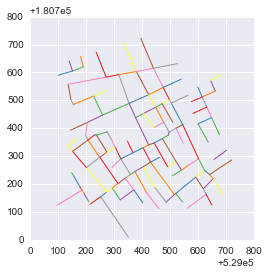

In [171]:
# Load point data
pumps = gpd.read_file(js_path+'Pumps.shp')
# Load building blocks
blocks = gpd.read_file(js_path+'polys.shp')
# Load street network
js = gpd.read_file(js_path+'streets_js.shp')
# Quickly plot the streets
js.plot(colormap='Set1')

And, since it is a full-fledge `GeoDataFrame`, we can also inspect its top rows the same way as with polygons:

In [172]:
js.head()

,Deaths,Deaths_dens,geometry,segIdStr,seg_len
0,0,0.000000,"LINESTRING (529521 180866, 529516 180862)",s0-1,6.403124
1,1,1.077897,"LINESTRING (529521 180866, 529592.98 180924.53)",s0-2,92.773279
2,0,0.000000,"LINESTRING (529521 180866, 529545 180836)",s0-3,38.418745
3,0,0.000000,"LINESTRING (529516 180862, 529487 180835)",s1-25,39.623226
4,26,18.079549,"LINESTRING (529516 180862, 529431 180978)",s1-27,143.808901


Before we move on to the analytical part, we can also create choropleth maps for line data in very much the same way as we have with polygons. In the following code snippet, we build a choropleth using the Fisher-Jenks classification for the density of cholera deaths in each street segment, and style it by adding a background color, building blocks and the location of the water pumps:

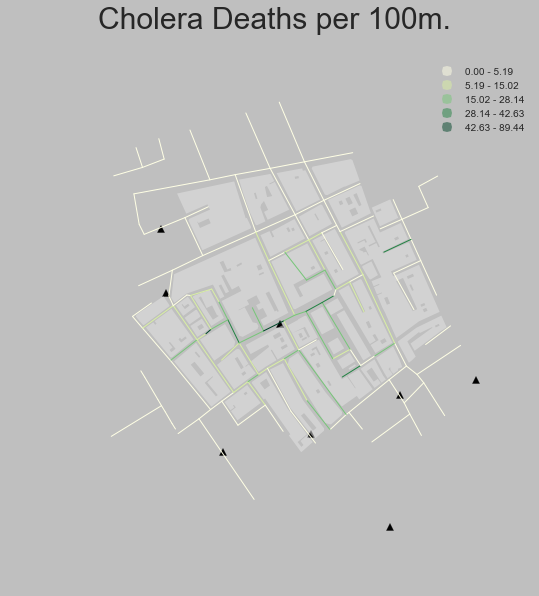

In [124]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot building blocks
for poly in blocks['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='0.9', linewidth=0)
# Quantile choropleth of deaths at the street level
js.plot(column='Deaths_dens', scheme='fisher_jenks', axes=ax, \
        colormap='YlGn', legend=True)
# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Keep axes proportionate
plt.axis('equal')
# Title
f.suptitle('Cholera Deaths per 100m.', size=30)
# Draw
plt.show()

---

**[Optional exercise]**

Create a similar map as above but using a quantile classification and an equal interval one. How do the maps differ? How do you think the distribution of values is for this dataset? Confirm your hunch by generating a density/histogram plot.

---

### Spatial weights matrix

As discused before, a spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. We have seen already many of the conceptual ways in which we can define a spatial weights matrix, such as contiguity, distance-based, or block. Although the examples we have considered so far relate to points and polygons, these ideas can also be applied with spatial networks made of line segments.

For this example, we will show how to build a simple contiguity matrix, which considers two observations as neighbors if they share one edge. In other words, for a street network as in our example, two street segments will be connected if they "touch" each other. Since lines only have one dimension, there is no room for the discussion between "queen" and "rook" criteria, but only one type of contiguity.

Technically speaking, building a contiguity matrix from a spatial network like the streets of London's Soho can be done with `PySAL`, but the route to creating it is slightly different. For this task, instead of the `ps.queen_from_shapefile`, we will use the network module of the library, which reads a line shapefile and creates a network representation of it. Once loaded, a contiguity matrix can be easily created using the `contiguityweights` attribute. To keep things aligned, we rename the IDs of the matrix to match those in the table and, finally, we row-standardize the matrix, which is a standard `ps.W` object, like those we have been working with for the polygon and point cases:

In [56]:
# Load the network
ntw = ps.Network(js_path+'streets_js.shp')
# Create the spatial weights matrix
w = ntw.contiguityweights(graph=False)
# Rename IDs to match those in the `segIdStr` column
w.remap_ids(js['segIdStr'])
# Row standardize the matrix
w.transform = 'R'

Island id:  [(73, 74)]


**Pro-tip**: Note also how, when we create the contiguity weights, we include the argument `graph=False`. This makes sure that we consider each street segment as it is represent in the shapefile, not as represented by the internal graph.

### Spatial lag

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the death density. Remember the spatial lag is the product of the spatial weights matrix and a given variable and that, if $W$ is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

We can calculate the spatial lag for the variable `Deaths_dens` and store it directly in the main table with the following line of code:

In [127]:
js['w_Deaths_dens'] = ps.lag_spatial(w, js['Deaths_dens'])

For some of the techniques we will be seeing below, it makes more sense to operate with the standardized version of a variable, rather than with the raw one. Standardizing means to substract the average value and divide by the standard deviation each observation of the column. This can be done easily with a bit of basic algebra in Python:

In [128]:
js['Deaths_dens_std'] = (js['Deaths_dens'] - js['Deaths_dens'].mean()) / js['Deaths_dens'].std()

Finally, to be able to explore the spatial patterns of the standardized values, also called sometimes $z$ values, we need to create its spatial lag:

In [129]:
js['w_Deaths_dens_std'] = ps.lag_spatial(w, js['Deaths_dens_std'])

## Global Spatial autocorrelation

* Moran Plot

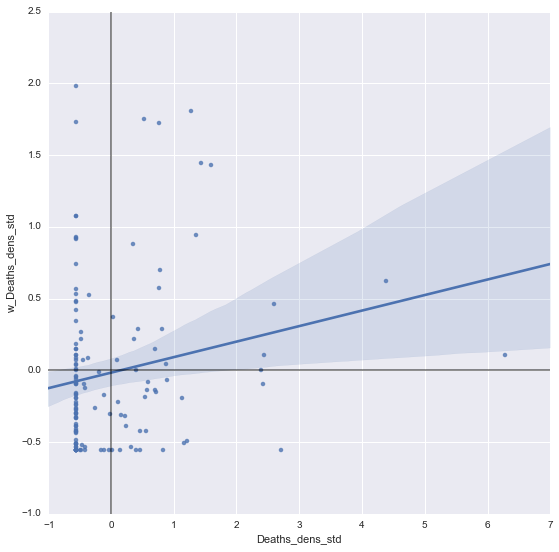

In [130]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_Deaths_dens_std', data=js)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

* Moran's I

In [173]:
mi = ps.Moran(js['Deaths_dens'], w)

In [174]:
mi.I

0.10902663995497329

* Inference on Moran's I (seaborn band)

In [136]:
mi.p_sim

0.050700000000000002

## Local Spatial autocorrelation

* Moran Plot and Quadrants

* LISAs

In [167]:
lisa = ps.Moran_Local(js['Deaths_dens'].values, w)

In [168]:
js['significant'] = lisa.p_sim < 0.05
js['quadrant'] = lisa.q

From `PySAL` documentation:
* 1 HH
* 2 LH
* 3 LL
* 4 HL

* LISA cluster maps

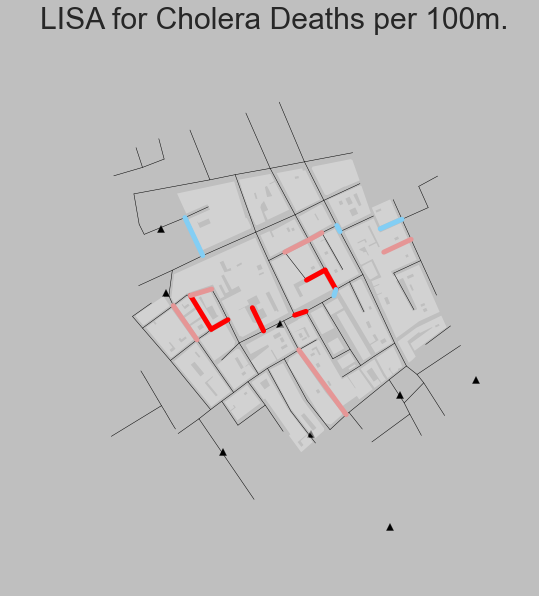

In [169]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot building blocks
for poly in blocks['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='0.9', linewidth=0)
# Plot baseline street network
for line in js['geometry']:
    gpd.plotting.plot_multilinestring(ax, line, color='k', linewidth=0.5)
# Plot HH clusters
hh = js.loc[(js['quadrant']==1) & (js['significant']==True), 'geometry']
for line in hh:
    gpd.plotting.plot_multilinestring(ax, line, color='red', linewidth=5)
# Plot LL clusters
ll = js.loc[(js['quadrant']==3) & (js['significant']==True), 'geometry']
for line in ll:
    gpd.plotting.plot_multilinestring(ax, line, color='blue', linewidth=5)
# Plot LH clusters
lh = js.loc[(js['quadrant']==2) & (js['significant']==True), 'geometry']
for line in lh:
    gpd.plotting.plot_multilinestring(ax, line, color='#83cef4', linewidth=5)
# Plot HL clusters
hl = js.loc[(js['quadrant']==4) & (js['significant']==True), 'geometry']
for line in hl:
    gpd.plotting.plot_multilinestring(ax, line, color='#e59696', linewidth=5)
# Plot pumps
xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Style and draw
f.suptitle('LISA for Cholera Deaths per 100m.', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.axis('equal')
plt.show()

## Main exercise

Replicate the analysis above for the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a simple choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

## `[Extension]` Spatial autocorrelation interactive visualization

If you are interested in the interactive visualization used in class to demonstrate the concept of spatial autocorrelation, you can find the online version of the notebook, executable directly from the browser and without the need to install anything, on the following link:

> [http://mybinder.org/repo/darribas/int_sp_auto](http://mybinder.org/repo/darribas/int_sp_auto)

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'15 - Lab 6</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

